Based on https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [4]:
# Root directory for dataset
dataroot = "/content/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Download celebA dataset from https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html, Aligned&Cropped Images

In [5]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/img_align_celeba.zip ', 'r') as zip_ref:
    zip_ref.extractall('/content/celeba')  # Extract to the /content directory

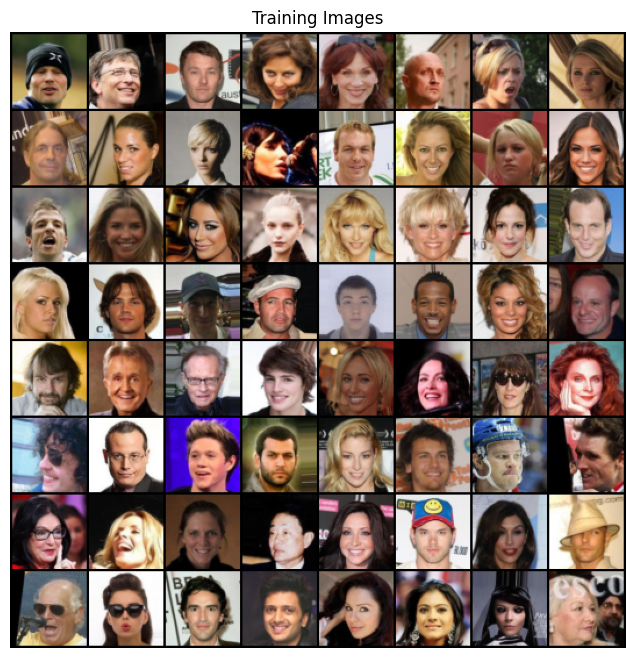

In [6]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [7]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [12]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [13]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 1.6264	Loss_G: 5.5242	D(x): 0.5733	D(G(z)): 0.5501 / 0.0065
[0/5][50/1583]	Loss_D: 0.0042	Loss_G: 31.3684	D(x): 0.9960	D(G(z)): 0.0000 / 0.0000
[0/5][100/1583]	Loss_D: 0.1501	Loss_G: 6.8574	D(x): 0.9124	D(G(z)): 0.0155 / 0.0021
[0/5][150/1583]	Loss_D: 0.7997	Loss_G: 3.5509	D(x): 0.6815	D(G(z)): 0.1232 / 0.0482
[0/5][200/1583]	Loss_D: 0.4158	Loss_G: 5.2472	D(x): 0.8302	D(G(z)): 0.1303 / 0.0081
[0/5][250/1583]	Loss_D: 0.9592	Loss_G: 6.2111	D(x): 0.8490	D(G(z)): 0.4442 / 0.0038
[0/5][300/1583]	Loss_D: 0.4895	Loss_G: 6.3228	D(x): 0.8911	D(G(z)): 0.2544 / 0.0044
[0/5][350/1583]	Loss_D: 0.8617	Loss_G: 1.9970	D(x): 0.5754	D(G(z)): 0.0476 / 0.1804
[0/5][400/1583]	Loss_D: 1.0753	Loss_G: 3.3974	D(x): 0.4815	D(G(z)): 0.0151 / 0.0579
[0/5][450/1583]	Loss_D: 0.7966	Loss_G: 7.4097	D(x): 0.8866	D(G(z)): 0.4212 / 0.0015
[0/5][500/1583]	Loss_D: 0.5193	Loss_G: 3.2701	D(x): 0.7459	D(G(z)): 0.1291 / 0.0589
[0/5][550/1583]	Loss_D: 0.3007	Loss_G: 4.6170	D(x): 

In [14]:
def random_unit_sphere(n, d):
    rand_vec = []
    i = 0
    while i < n:
        x = np.random.normal(0, 1, size=(d, ))
        dist = np.linalg.norm(x)
        if dist < 0.0001:
            continue
        x = x/dist
        i += 1
        rand_vec.append(x)
    return rand_vec

In [15]:
def cauchy_generator():
    u = np.random.rand(1)
    return np.tan(np.pi*u/2)

In [16]:
def levy_flight(n, d):
    rand_vec = random_unit_sphere(n, d)
    pos = []
    pos.append(rand_vec[0])
    max_x = rand_vec[0][0]
    min_x = rand_vec[0][0]
    max_y = rand_vec[0][1]
    min_y = rand_vec[0][1]
    max_z = rand_vec[0][2]
    min_z = rand_vec[0][2]
    for i in range(1,n):
        v = pos[i-1] + cauchy_generator()*rand_vec[i]
        pos.append(v)
        if v[0] > max_x:
            max_x = v[0]
        if v[0] < min_x:
            min_x = v[0]
        if v[1] > max_y:
            max_y = v[1]
        if v[1] < min_y:
            min_y = v[1]
        if v[2] > max_z:
            max_z = v[2]
        if v[2] < min_z:
            min_z = v[2]
    lim = [max_x, min_x, max_y, min_y, max_z, min_z]
    return pos, lim

In [ ]:
pos,_ = levy_flight(100,b_size*nz)

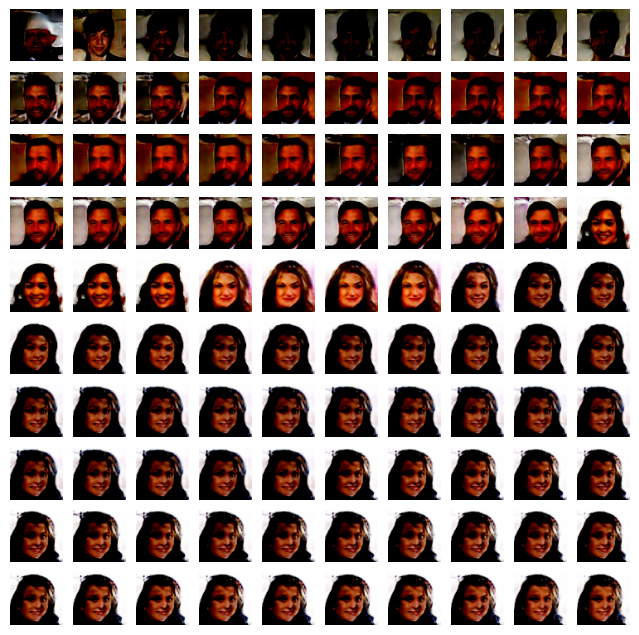

In [ ]:
#100-step Levy flight
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
  noise = torch.from_numpy(np.reshape(pos[i], (b_size,nz,1,1)))
  noise_float = noise.float()
  noise = noise_float.to(device)
  img = netG(noise)
  img = img.detach().cpu()
  img = img.numpy()
  ax.imshow((np.transpose(img[0,:,:,:],(1,2,0))))
  ax.axis('off')
plt.show()

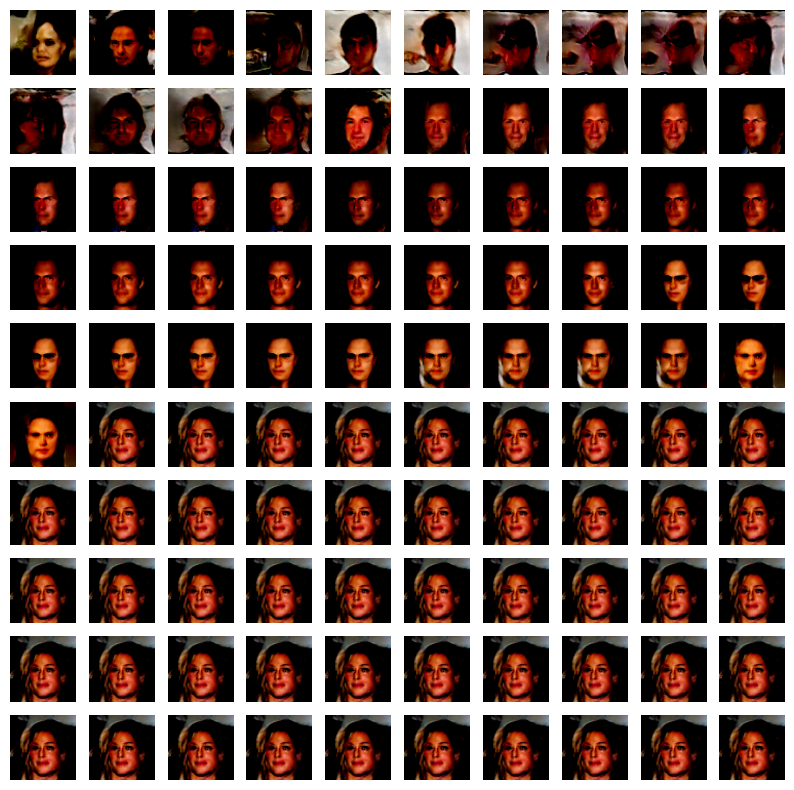

In [68]:
# 200-step Levy flight
pos,_ = levy_flight(200,b_size*nz)
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
  # print(np.shape(pos[i]))
  noise = torch.from_numpy(np.reshape(pos[2*i], (b_size,nz,1,1)))
  noise_float = noise.float()
  noise = noise_float.to(device)
  img = netG(noise)
  img = img.detach().cpu()
  img = img.numpy()
  # Clip the data to the range [0,1]
  img = np.clip(img, 0, 1)
  ax.imshow((np.transpose(img[0,:,:,:],(1,2,0))))
  ax.axis('off')
plt.show()

In [54]:
pos,_ = levy_flight(500,b_size*nz)

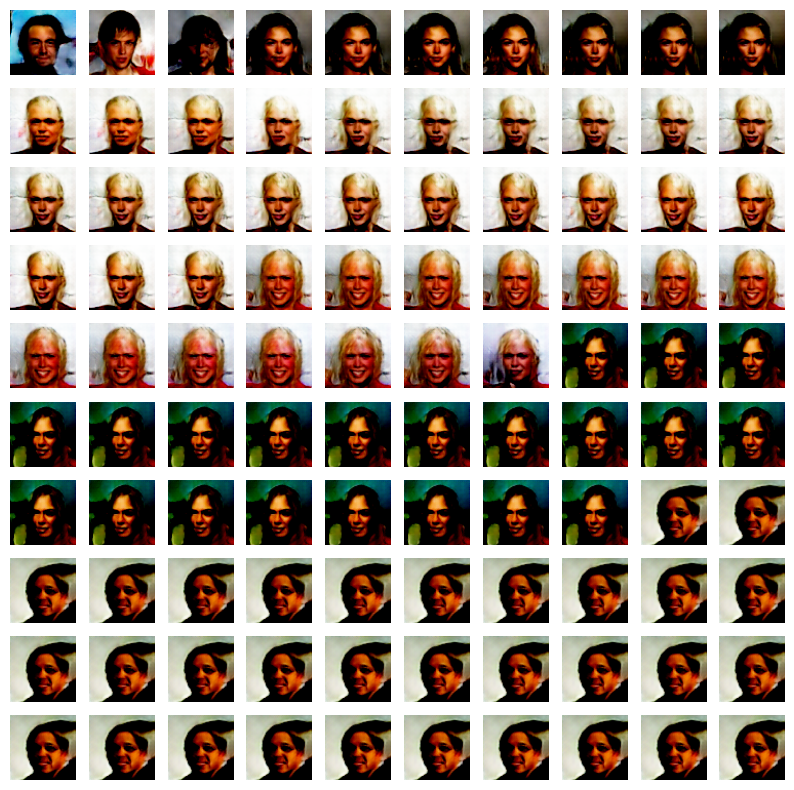

In [55]:
# 500-step Levy flight
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
  # print(np.shape(pos[i]))
  noise = torch.from_numpy(np.reshape(pos[5*i], (b_size,nz,1,1)))
  noise_float = noise.float()
  noise = noise_float.to(device)
  # rescaling
  # min = np.min(img)
  # max = np.max(img)
  # img = (img-min)/(max-min)
  img = netG(noise)
  img = img.detach().cpu()
  img = img.numpy()
  # Clip the data to the range [0,1]
  img = np.clip(img, 0, 1)
  ax.imshow((np.transpose(img[0,:,:,:],(1,2,0))))
  ax.axis('off')
plt.show()

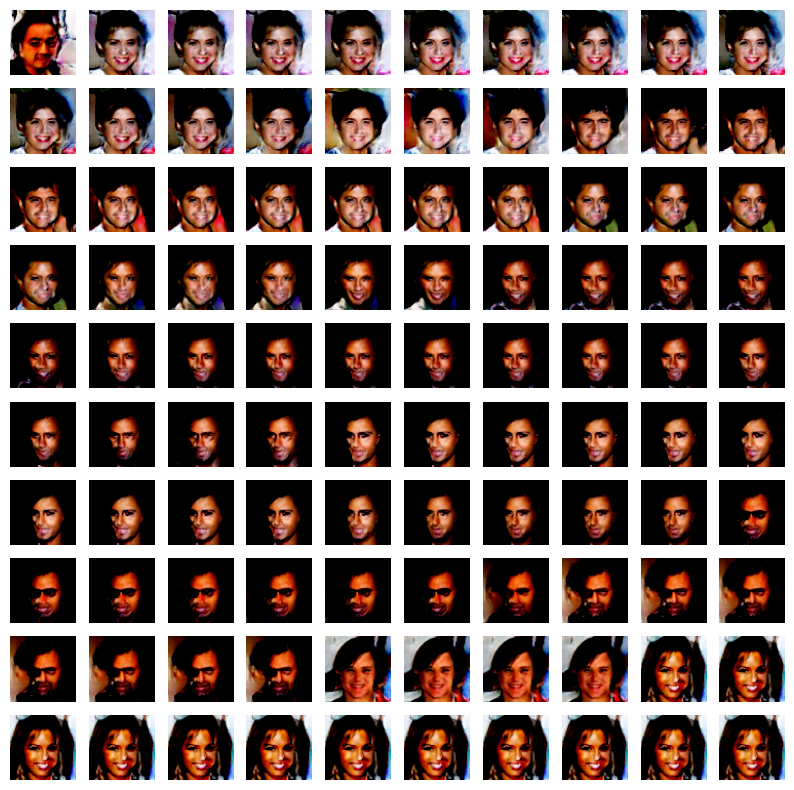

In [47]:
# 1000-step Levy flight
pos,_ = levy_flight(1000,b_size*nz)

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
  # print(np.shape(pos[i]))
  noise = torch.from_numpy(np.reshape(pos[10*i], (b_size,nz,1,1)))
  noise_float = noise.float()
  noise = noise_float.to(device)
  img = netG(noise)
  img = img.detach().cpu()
  img = img.numpy()
  # Clip the data to the range [0,1]
  img = np.clip(img, 0, 1)
  ax.imshow((np.transpose(img[0,:,:,:],(1,2,0))))
  ax.axis('off')
plt.show()

In [43]:
def brownian(n, d, sigma=1):
    rand_vec = random_unit_sphere(n, d)
    pos = []
    pos.append(rand_vec[0])
    max_x = rand_vec[0][0]
    min_x = rand_vec[0][0]
    max_y = rand_vec[0][1]
    min_y = rand_vec[0][1]
    max_z = rand_vec[0][2]
    min_z = rand_vec[0][2]
    for i in range(1,n):
        v = pos[i-1] + np.random.normal(0,sigma)*rand_vec[i]
        pos.append(v)
        if v[0] > max_x:
            max_x = v[0]
        if v[0] < min_x:
            min_x = v[0]
        if v[1] > max_y:
            max_y = v[1]
        if v[1] < min_y:
            min_y = v[1]
        if v[2] > max_z:
            max_z = v[2]
        if v[2] < min_z:
            min_z = v[2]
    lim = [max_x, min_x, max_y, min_y, max_z, min_z]
    return pos, lim

Compare with Brownian motion

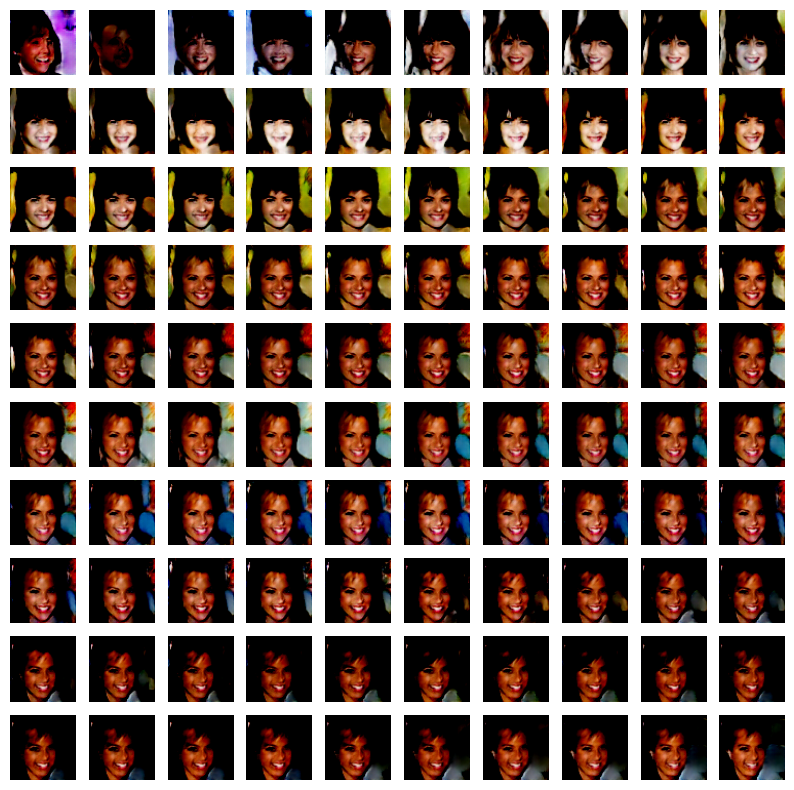

In [49]:
# 1000-step Brownian motion, with variance=1
pos,_ = brownian(1000,b_size*nz)
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
  # print(np.shape(pos[i]))
  noise = torch.from_numpy(np.reshape(pos[10*i], (b_size,nz,1,1)))
  noise_float = noise.float()
  noise = noise_float.to(device)
  img = netG(noise)
  img = img.detach().cpu()
  img = img.numpy()
  # Clip the data to the range [0,1]
  img = np.clip(img, 0, 1)
  ax.imshow((np.transpose(img[0,:,:,:],(1,2,0))))
  ax.axis('off')
plt.show()

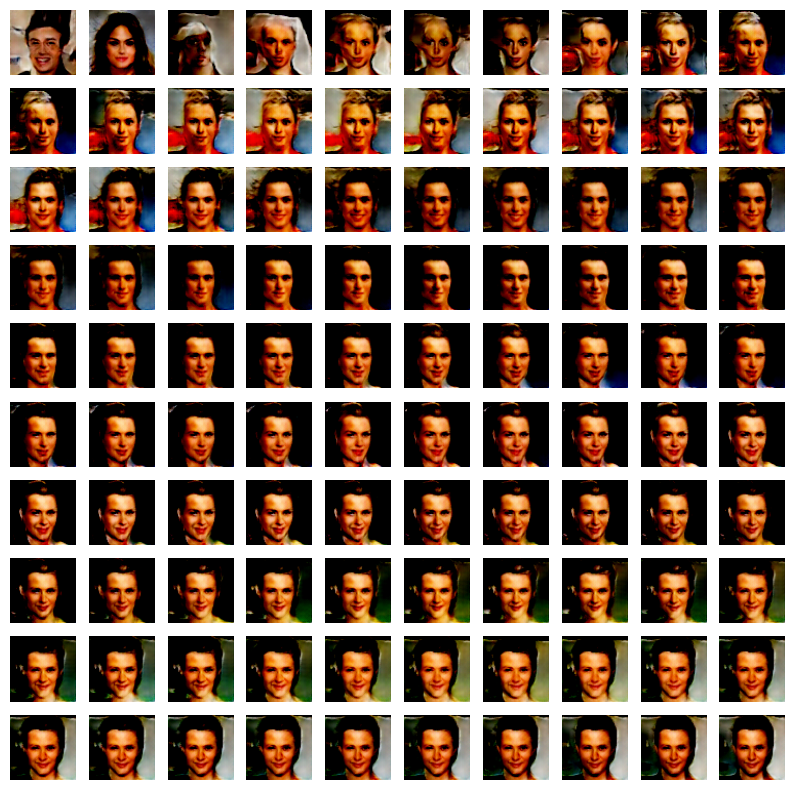

In [45]:
# Increasing variance to 100
pos,_ = brownian(1000,b_size*nz, 100)
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
  # print(np.shape(pos[i]))
  noise = torch.from_numpy(np.reshape(pos[10*i], (b_size,nz,1,1)))
  noise_float = noise.float()
  noise = noise_float.to(device)
  img = netG(noise)
  img = img.detach().cpu()
  img = img.numpy()
  # Clip the data to the range [0,1]
  img = np.clip(img, 0, 1)
  ax.imshow((np.transpose(img[0,:,:,:],(1,2,0))))
  ax.axis('off')
plt.show()